# Spam Detection

<div class="alert alert-info">
Note: This document contains AI generated content - code and editing refinement provided by GPT-3 class models. 
</div>

<div>
<img src="images/spam_spam.png" width="500"/>
</div>



Welcome to the Modeling Deep Dive Section of **MLPROD 310.**

* [Canvas Link](https://canvas.uw.edu/courses/1424648)
* [Course Information](https://www.pce.uw.edu/specializations/machine-learning-product-management)

This document is an overview of an example spam detection model, and how one might go about building a pipeline for training and evaluation of a simple spam detector using simple modeling components.

The notebook is broken down into several steps, and outlines some of the options/caveats that are inherent to the step.  The notebook selects basic steps that build on simpler linear and neural network architectures, but don't necessarily suggest that the chosen architectures are the "best" overall.

## Introduction
Spam detection is the process of identifying and filtering unwanted or malicious messages, such as emails, SMS, or social media posts. Spam can range from harmless but annoying advertisements to dangerous phishing attempts and malware distribution. Given the vast volume of digital communication, automated spam detection systems are essential for maintaining security, efficiency, and user experience.  This article walks through the construction of a spam classifier using open source models and tooling.  The article itself is written as a jupyter notebook and rendered to html.  The original jupyter notebook is avaialable [here](https://github.com/jdonaldson/jjd.io/blob/main/posts/Spam%20Detector.ipynb)

Building an optimal spam detection model involves multiple considerations, including data collection, feature selection, model choice, and evaluation. The decision-making process typically follows these key steps:

1. **Defining the Problem Scope**

* What type of spam needs to be detected (emails, SMS, social media posts, etc.)?

* What is the acceptable trade-off between false positives (legitimate messages flagged as spam) and false negatives (spam messages that get through)?

2. **Data Collection and Preprocessing**

* Gathering labeled datasets of spam and non-spam messages.

* Cleaning the data by removing noise, tokenizing text, and handling missing values.

* Augmenting data with additional signals like sender reputation, message structure, and frequency patterns.

3. **Feature Engineering**

* Extracting relevant features such as word frequency, n-grams, TF-IDF scores, or embeddings from NLP models.

* Incorporating metadata features (e.g., sender history, link presence, HTML content).

4. **Model Selection**

* Choosing between rule-based systems, classical machine learning models (Naïve Bayes, SVMs, Random Forests), or deep learning approaches (LSTMs, Transformers).

* Evaluating trade-offs between interpretability, computational cost, and effectiveness.

5. **Training**

* Splitting data into training, validation, and test sets.


6. **Evaluation**

* Using metrics like precision, recall, F1-score, and ROC-AUC to assess performance.

* Implementing techniques like cross-validation and hyperparameter tuning to optimize the model.





## Step 1 : Define Scope

For the purposes of this exercise we'll look at e-mail messages that contain known spam or non-spam ("ham") messages.

There's a variety of techniques that are useful for detecting spam, including 

* [TF/IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
    * Collecting and comparing word and document frequencies of spam/non-spam sources and creating message vectors.
    * Pros : Easy conceptual components, requires understanding of information entropy.
    * Cons : Doesn't handle typos or unknown words well, normalized vectors can be enormous.
* [Word Embedding](https://en.wikipedia.org/wiki/Word_embedding) (Concatenated)
    * Creating/Using word embeddings such as Word2Vec and concatenating into a message embedding.
    * Pros: 10-100x faster than sentence embeddings.  Effective for simple descriptive phases.
    * Cons: Concatenated word embeddings can lose a lot of precision with even a handful of concatenated word vectors.
* [Sentence Embedding](https://en.wikipedia.org/wiki/Sentence_embedding)
    * Creating/Using sentence embeddings such as SentenceBert into message embeddings.
    * Pros: 10-100x faster than instruction embeddings.  Effective for capturing complex semantic sentence structure.
    * Cons: Not nearly as fast as word embeddings, nor are they capable of handling specific instructions.
* [Transformer Embedding](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)) (GPT >=3)
    * Creating/Using instruction embeddings from larger models.
    * Pros: Possible to "program" embeddings using special instructions (give instructions that give more clear separation between records based on context).
    * Cons: Much more expensive and time consuming to execute.
    
# Evolution of Text Representation Models: Size and Capabilities

| Model Type | Typical Size | Dimensionality | Context Window | Training Data Requirements | Key Capabilities | Limitations |
|------------|--------------|----------------|----------------|----------------------------|-----------------|-------------|
| **TF-IDF** | Very small<br>(KB to MB) | Sparse vectors<br>(Dictionary size) | Document/corpus level | Minimal<br>(Just the target corpus) | • Simple statistical word importance<br>• Effective for document classification<br>• Computationally efficient<br>• No pre-training required | • No semantic understanding<br>• No word relationships<br>• Sparse representation<br>• Fixed vocabulary |
| **Word Vectors**<br>(word2vec, GloVe) | Small<br>(100MB-1GB) | Dense vectors<br>(50-300) | Word level | Medium<br>(1B+ tokens) | • Captures semantic relationships<br>• Word analogies (king - man + woman = queen)<br>• Transfer learning for downstream tasks<br>• Efficient inference | • Static word representations<br>• No context sensitivity<br>• No sentence-level understanding<br>• Word ambiguity issues |
| **Sentence Embeddings**<br>(USE, InferSent, SBERT) | Medium<br>(1-5GB) | Dense vectors<br>(512-1024) | Sentence level | Large<br>(10B+ tokens) | • Sentence-level semantics<br>• Better for similarity tasks<br>• Cross-lingual capabilities<br>• Effective for retrieval | • Limited contextual understanding<br>• Fixed-length representations<br>• Less effective for long documents<br>• Limited compositional abilities |
| **Small Transformers**<br>(BERT-base, RoBERTa-base) | Medium<br>(0.5-1GB) | Contextual vectors<br>(768-1024) | Limited<br>(512 tokens) | Very large<br>(30B+ tokens) | • Contextual word representations<br>• Bidirectional context<br>• Strong performance on many NLP tasks<br>• Fine-tuning capabilities | • Limited context window<br>• Moderate parameter efficiency<br>• Training compute requirements<br>• Still primarily linguistic understanding |
| **Large Transformers**<br>(GPT-3, PaLM, Claude) | Very large<br>(100GB-1TB+) | Contextual vectors<br>(2048-12288+) | Large<br>(8K-100K+ tokens) | Massive<br>(1T+ tokens) | • Few/zero-shot learning<br>• Long-range dependencies<br>• Emergent abilities<br>• Cross-task generalization<br>• Natural language generation | • Enormous compute requirements<br>• Training cost<br>• Potential for biased outputs<br>• "Black box" behavior<br>• Challenging to interpret |




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Create DataFrame with model data
data = {
    'name': ['TF-IDF', 'Word2Vec', 'GloVe', 'BERT-base', 'RoBERTa', 'GPT-2', 
             'T5-large', 'GPT-3', 'PaLM', 'GPT-4'],
    'year': [2000, 2013, 2014, 2018, 2019, 2019, 2020, 2020, 2022, 2023],
    'size': [0.001, 0.3, 0.5, 0.4, 0.5, 1.5, 3, 175, 540, 1500],  # Size in GB
    'capability': [
        'Basic word importance/Document classification',
        'Word relationships/Word analogies',
        'Global corpus statistics/Improved semantic capture',
        'Contextual representation/Bidirectional understanding',
        'Optimized pre-training/State-of-art on benchmarks',
        'Better text generation/Zero-shot learning',
        'Text-to-text framework/Multi-task learning',
        'Few-shot learning/Complex instructions',
        'Chain-of-thought reasoning/Advanced problem solving',
        'Nuanced reasoning/Multimodal understanding'
    ]
}

df = pd.DataFrame(data)

# Sort by year for proper timeline
df = df.sort_values(by=['year', 'size'])

# Create figure and axis
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Plot with log scale for y-axis to handle the dramatic size differences
ax.semilogy(df['year'], df['size'], marker='o', markersize=10, 
            linewidth=2, color='#2563eb')

# Format y-axis to show values nicely
def size_formatter(x, pos):
    if x < 1:
        return f"{x:.3f}"
    else:
        return f"{int(x) if x == int(x) else x:.1f}"

ax.yaxis.set_major_formatter(FuncFormatter(size_formatter))

# Add annotations for each model
for i, row in df.iterrows():
    # Determine annotation placement (above or below point based on position)
    if row['size'] > 10:
        y_offset = -1.2  # Place below for large models
        va = 'top'
    else:
        y_offset = 1.2  # Place above for small models
        va = 'bottom'
    
    # Add model name
    ax.annotate(
        f"{row['name']}",
        xy=(row['year'], row['size']),
        xytext=(0, 20 * y_offset),
        textcoords="offset points",
        ha='center',
        va=va,
        fontweight='bold',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9)
    )
    
    # Add capability text in smaller font
    ax.annotate(
        f"{row['capability']}",
        xy=(row['year'], row['size']),
        xytext=(0, 45 * y_offset),
        textcoords="offset points",
        ha='center',
        va=va,
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", fc="#f0f7ff", ec="#c7dbff", alpha=0.9),
        wrap=True
    )

# Add labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Model Size (GB)', fontsize=12)
plt.title('Growth in NLP Model Size (2000-2023)', fontsize=14, fontweight='bold')

# Add grid for better readability (especially with log scale)
plt.grid(True, which="both", ls="-", alpha=0.2)

# Adjust the x-axis to give some padding
x_min, x_max = df['year'].min() - 1, df['year'].max() + 1
plt.xlim(x_min, x_max)

# Add a note about log scale
plt.figtext(0.5, 0.01, 
           "Note: Y-axis uses logarithmic scale to visualize the exponential growth in model size", 
           ha="center", fontsize=9, style='italic')

# Layout adjustment to make space for annotations
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
plt.savefig('nlp_model_size_growth.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Display the data as a table
print("\nNLP Model Size and Capability Data:")
print(df[['name', 'year', 'size', 'capability']].to_string(index=False))

In [1]:
## If you have jupyter lab running already, just uncomment this cell to install what you need.
# !pip install polars sentence-transformers tqdm pyarrow altair ipywidgets pandas matplotlib

# Step 2. Install Dependencies

## Required Python Packages
The following Python packages are needed for the project:

- [`polars`](https://pola.rs/) – Fast DataFrame library  
- [`sentence-transformers`](https://www.sbert.net/) – Pre-trained models for sentence embeddings  
- [`tqdm`](https://tqdm.github.io/) – Progress bar library  
- [`pyarrow`](https://arrow.apache.org/docs/python/) – Apache Arrow for fast data processing  
- [`altair`](https://altair-viz.github.io/) – Declarative statistical visualization library  
- [`ipywidgets`](https://ipywidgets.readthedocs.io/en/stable/) – Interactive widgets for Jupyter notebooks  
- [`pandas`](https://pandas.pydata.org/) – Data analysis library  
- [`matplotlib`](https://matplotlib.org/) – Visualization library  

We will call out specific libraries and their strengths and weaknesses.

## Recommended: Install Miniconda
Using Miniconda is highly recommended to manage dependencies efficiently. Follow the instructions below to install Miniconda and set up an environment.

### **1. Install Miniconda**
#### **Mac & Linux**
Run the following commands in a terminal:

```bash
# Download Miniconda installer
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
# OR for macOS (Intel)
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-MacOSX-x86_64.sh -O miniconda.sh
# OR for macOS (Apple Silicon)
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-MacOSX-arm64.sh -O miniconda.sh

# Install Miniconda
bash miniconda.sh -b -p $HOME/miniconda

# Initialize Conda
$HOME/miniconda/bin/conda init
```

Restart your terminal for the changes to take effect.

#### **Windows**
1. Download the latest [Miniconda installer](https://repo.anaconda.com/miniconda/Miniconda3-latest-Windows-x86_64.exe).
2. Run the installer and follow the on-screen instructions.
3. Open **Anaconda Prompt** or **PowerShell**, then initialize Conda:
   ```powershell
   conda init
   ```

Restart your terminal or PowerShell session.

### **2. Create a Conda Environment**
Create and activate a new environment named `myenv` (or another name of your choice):

```bash
conda create -n myenv python=3.10 -y
conda activate myenv
```

### **3. Install Required Packages**
With the Conda environment activated, install the required packages:

```bash
pip install polars sentence-transformers tqdm pyarrow altair ipywidgets pandas matplotlib
```

### **4. Verify Installation**
To check that everything is installed correctly, run:

```bash
python -c "import polars, sentence_transformers, tqdm, pyarrow, altair, ipywidgets, pandas, matplotlib; print('All packages installed successfully!')"
```

### **5. Launch JupyterLab**
To start JupyterLab, run:

```bash
jupyter lab
```

You should see this notebook :)

## Step 3: Data Collection and Processing

In [11]:
import polars as pl
df = pl.read_csv("https://raw.githubusercontent.com/bigmlcom/python/refs/heads/master/data/spam.csv", separator = "\t")
df.glimpse()

Rows: 656
Columns: 2
$ Type    <str> 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'spam', 'spam'
$ Message <str> 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though", "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv", 'Even my brother is not like to speak with me. They treat me like aids patent.', "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune", 'WINNER!! As a valued network customer you have been 

# Step 4: Feature Engineering

Let's try [MiniLM](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), a lightweight sentence embedding model.

We can create embeddings from the messages, and insert them back into the dataset as a separate column.  Note how Jupyter allows one to use typed (f32x384) vectors as a column type.  Pandas can not do this, and is one of the reasons Polars is recommended.  However, Polars is still very new and is rapidly evolving.  Make sure to stay [up to date on documentation](https://pola.rs/).

In [48]:
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")


In [49]:
# Create the embeddings and save them efficiently as a numpy array
embeddings = sentence_model.encode(df["Message"].to_numpy())

# Bind the numpy array to the rest of the dataframe
df = df.with_columns([
    pl.Series(embeddings).alias("Message_Embeddings")
])
df.head()

Type,Message,Message_Embeddings
str,str,"array[f32, 384]"
"""ham""","""Go until jurong point, crazy..…","[-0.016918, -0.038168, … -0.001258]"
"""ham""","""Ok lar... Joking wif u oni...""","[-0.013369, -0.04987, … -0.003396]"
"""spam""","""Free entry in 2 a wkly comp to…","[-0.015434, 0.063041, … 0.015645]"
"""ham""","""U dun say so early hor... U c …","[-0.012308, 0.037198, … -0.003828]"
"""ham""","""Nah I don't think he goes to u…","[0.0777, -0.132872, … 0.009034]"


# Step 5: Model Selection

There's a number of different approaches we could take, but for the purposes of illustration, one has landed on using a simpler linear model on top of sentence embeddings.

In [ ]:
# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Single output node
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

# Step 6: Training

We will define a training loop.  Since we are borrowing a sentence embedder with MiniLM, we don't need to train a new one.  However, we will need to train a simpler linear model. 


In [41]:
# This cell contains a mix of AI and Human Generated Code.
import polars as pl
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert labels to binary (spam = 1, ham = 0) and keep as a Polars expression
df = df.with_columns((pl.col("Type") == "spam").cast(pl.Int32).alias("Label"))

# Convert Polars columns directly to PyTorch tensors

X = torch.tensor(df["Message_Embeddings"], dtype=torch.float32)  # Embeddings tensor
y = torch.tensor(df["Label"], dtype=torch.float32).unsqueeze(1)  # Labels tensor

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Initialize model
input_dim = X.shape[1]  # Get embedding size
model = LogisticRegression(input_dim)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
holdout_metrics = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        # Evaluate the model on the holdout
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test)
            holdout_loss = criterion(y_pred, y_test)
            y_pred_labels = (y_pred > 0.5).float()  # Convert probabilities to binary (0 or 1)

        # Convert tensors to NumPy arrays for sklearn metrics
        y_test_np = y_test.numpy()
        y_pred_np = y_pred_labels.numpy()

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test_np, y_pred_np)
        metrics = {
            "epoch" : epoch,
            "loss" : loss.item(),
            "holdout_loss" : holdout_loss.item(),
            "holdout_accuracy" : accuracy,
        }
        holdout_metrics.append(metrics)

metrics = pd.DataFrame(holdout_metrics).set_index("epoch")
metrics

,loss,holdout_loss,holdout_accuracy
epoch,,,
0,0.688025,0.662975,0.871212
10,0.485827,0.480892,0.878788
20,0.371861,0.383493,0.878788
30,0.306713,0.330718,0.878788
40,0.263094,0.296044,0.886364


# Step 7: Evaluation

We come to the all important evaluation step.  We need to assess the results and determine if the model is optimized.

1. We need to compare the loss metrics. Does the loss metrics make sense?  (Are they going down, is one loss better than the other?  Why?)
2. The holdout accuracy looks like 88%, which seems good.  Is it good enough?  What are some simple things we can do to make it better just by looking at the chart?


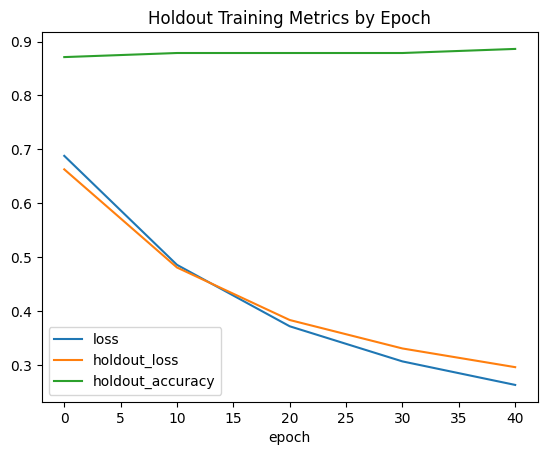

In [42]:
metrics.plot(title="Holdout Training Metrics by Epoch");

# Future Steps

At this point, a decision is reached whether to release the model as-is, or think of ways of improving performance.

1. What are some pieces of information that could be added to the training embedding/vector?  How?
2. What do we need to do to maintain this model?  How would we detect model drift? 
3. If we need to change from a binary classification model to a multi-class model, what needs to change?